In [1]:
import numpy as np
import sklearn.metrics
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow import keras
import tensorflow as tf
import pandas as pd
import DATALOADER
import sklearn.model_selection

In [19]:
df = pd.read_csv('train_results/KFOLD2022.06.17_01.55.45/KFOLD2022.06.17_01.55.45_log.csv')

In [20]:
np.max(df.val_accuracy)

0.7650323510169983

Text(0, 0.5, 'accuracy')

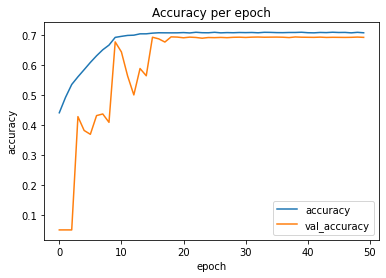

In [9]:
df[['accuracy', 'val_accuracy']].plot()
plt.title('Accuracy per epoch')
plt.xlabel('epoch')
plt.ylabel('accuracy')

Text(0, 0.5, 'accuracy')

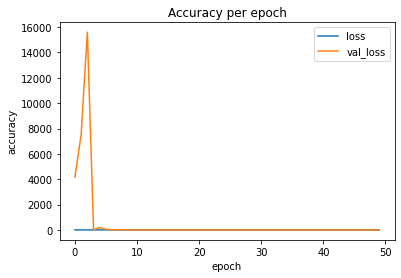

In [10]:
df[['loss', 'val_loss']].plot()
plt.title('Loss per epoch')
plt.xlabel('epoch')
plt.ylabel('loss')

In [12]:
df['log_loss'] = np.log(df['loss'])
df['log_val_loss'] = np.log(df['val_loss'])

Text(0, 0.5, 'loss')

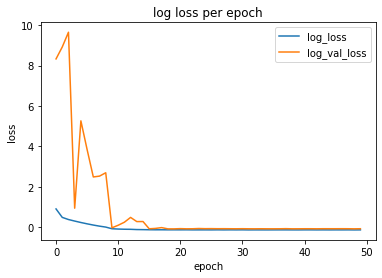

In [14]:
df[['log_loss', 'log_val_loss']].plot()
plt.title('log loss per epoch')
plt.xlabel('epoch')
plt.ylabel('loss')

In [6]:
#model_path = 'train_results/KFOLD2022.06.17_01.55.45/KFOLD2022.06.17_01.55.45_checkpoint'
model_path = 'train_results/2022.06.13_01.29.01_model.h5'
model = keras.models.load_model(model_path)
print(model.summary())
del model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 3, 3, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 12)                221196    
                                                                 
Total params: 23,785,996
Trainable params: 23,740,556
Non-trainable params: 45,440
_________________________________________________________________
None


In [4]:
model_path = 'train_results/2022.06.13_17.31.49_model.h5'
model = keras.models.load_model(model_path)
print(model.summary())
del model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 3, 3, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 256)               4718848   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                        

In [5]:
model_path = 'train_results/2022.06.14_10.13.38_model.h5'
model = keras.models.load_model(model_path)
print(model.summary())
del model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 3, 3, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 batch_normalization (BatchN  (None, 18432)            73728     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 12)                221196    
                                                                 
Total params: 23,859,724
Trainable params: 23,777,420
Non-trainable params: 82,304
_________________________________________________________________
None


In [6]:
model_path = 'train_results/2022.06.15_01.16.59_model.h5'
model = keras.models.load_model(model_path)
print(model.summary())
del model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, None, None, None)  0         
                                                                 
 random_rotation (RandomRota  (None, None, None, None)  0        
 tion)                                                           
                                                                 
 resnet50v2 (Functional)     (None, 3, 3, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 12)                221196    
                                                                 
Total params: 23,785,996
Trainable params: 23,740,556
Non-trainable params: 45,440
_______________________________________

In [3]:
path = 'Data_paths.csv'
df = pd.read_csv(path)
df = df[df.moa != 'DMSO']

In [4]:
labels = np.array(['Actin disruptors',
       'Aurora kinase inhibitors',
       'Cholesterol-lowering',
       'DNA damage',
       'DNA replication',
       'Eg5 inhibitors',
       'Epithelial',
       'Kinase inhibitors',
       'Microtubule destabilizers',
       'Microtubule stabilizers',
       'Protein degradation',
       'Protein synthesis'])

In [5]:
fold_y_true = []
fold_y_pred = []
fold_acc = []

In [6]:
moa_one_hot_encoder = sklearn.preprocessing.OneHotEncoder(sparse=False)
moa_one_hot_encoder.fit(df['moa'].to_numpy().reshape(-1, 1))

skf = sklearn.model_selection.StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)


input_tensor = tf.keras.Input(shape=(68,68,3))

for idx_fold, (idx_train, idx_test) in enumerate(skf.split(df['path'], df['moa'])):
    print(f"\n\nKfold iteration: {idx_fold+1}/{5}\n")
    df_valid = df.loc[idx_test]
    validation_dataloader = DATALOADER.DataLoader(df = df_valid, one_hot_encoder = moa_one_hot_encoder, batch_size = 32, input_size=(68,68,3), shuffle = False)

    y_pred = model.predict(validation_dataloader)
    #Confusion Matrix
    y_true = validation_dataloader.df.moa[0:len(y_pred)]
    y_pred = moa_one_hot_encoder.inverse_transform(y_pred)
    acc = sklearn.metrics.accuracy_score(y_true, y_pred)
    fold_y_true.append(y_true)
    fold_y_pred.append(y_pred)
    fold_acc.append(acc)
    print(acc)
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)

    fig = plt.figure(figsize=(10,10))
    ax = sns.heatmap(cm, annot=True, fmt='.2f')
    ax.set_yticklabels(labels)
    ax.set_xticklabels(labels)
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.tight_layout()
    plt.show()



Kfold iteration: 1/5



KeyboardInterrupt: 

In [ ]:
print(fold_acc)

In [ ]:
y_true = np.load('train_results\KFOLD2022.06.17_01.55.45\KFOLD2022.06.17_01.55.45_y_true_fold_1.npy', allow_pickle = True)
y_pred = np.load('train_results\KFOLD2022.06.17_01.55.45\KFOLD2022.06.17_01.55.45_y_pred_fold_1.npy', allow_pickle = True)

In [ ]:
y_true.shape

In [ ]:
y_pred.shape

In [ ]:
c = 0
for i in range(len(y_true)):
    if y_true[i] == 'Actin disruptors' and y_pred[i] != 'Actin disruptors':
        c += 1
print(c)

In [ ]:
c = 0
for i in range(len(y_true)):
    if y_true[i] == y_pred[i]:
        c += 1
print(c)

In [ ]:
c/len(y_true)*100

In [ ]:
count

In [ ]:
cms = sklearn.metrics.multilabel_confusion_matrix(y_true, y_pred)
count = Counter(y_true)
acc = []
for i in range(cms.shape[0]):
    cm = cms[i,:]
    label = labels[i][0]
    acc.append(cm[1,1]/ count[label]*100)
    
    cm[1,1] = cm[1,1] / count[label] * 100 
    
    ax = sns.heatmap(cm, annot=True, fmt='.2f')
    ax.set_yticklabels(['False', 'True'])
    ax.set_xticklabels(['Negative', 'Positive'])
    plt.title(label)
    plt.show()
print(sum(acc))